#  Яндекс. Тарифы мобильной связи.
<br>**Описание проекта.**<br> <br>
Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

##  Знакомство с данными.

In [1]:
import pandas as pd
import math as mt
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

In [2]:
calls_data = pd.read_csv ('calls.csv')
internet_data = pd.read_csv ('internet.csv')
messages_data = pd.read_csv ('messages.csv')
tariffs_data = pd.read_csv ('tariffs.csv')
users_data = pd.read_csv ('users.csv')

In [3]:
print (calls_data.head())
print (internet_data.head())
print (messages_data.head())
print (users_data.head())
print (tariffs_data.head())

print('')
print('Сводная информация о данных: calls_data')
calls_data.info()
print('')
print('Сводная информация о данных: internet_data')
internet_data.info()
print('')
print('Сводная информация о данных: messages_data')
messages_data.info()
print(' ')
print('Сводная информация о данных: users_data')
users_data.info()
print(' ')
print('Сводная информация о данных: tariffs_data')
tariffs_data.info()

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   

In [4]:
print ('Количество "нулевых" звонков:',calls_data[calls_data['duration'] == 0]['duration'].count())
print ('Количество "нулевых" интернет-соединений:',internet_data[internet_data['mb_used'] == 0]['mb_used'].count())

Количество "нулевых" звонков: 39613
Количество "нулевых" интернет-соединений: 19598


Звонки с нулевой длительностью, как и интернет-соединения с нулевых трафиком не тарифицируются, т.е. не представляют интереса для исследования. Поэтому отфильтруем их заранее, чтобы сэкономить время на обработку данных и память.

In [5]:
calls_data = calls_data[calls_data['duration'] != 0]
internet_data = internet_data[internet_data['mb_used'] != 0]

**Вывод** <br>
<br>
- Все таблицы, кроме tariffs_data, содержат общий столбец user_id, который позволяет однозначно идентифицировать в представленных данных каждого уникального пользователя.<br>
- Таблица tariffs_data содержит сводную, обезличенную информацию по каждому из тарифов. Принадлежность тарифов к конкретным пользователям представлена в таблице users_data. <br>
- Все таблицы содержат разное количество строк и столбцов. Однако, каждая из таблиц содержит сведения строго определённого характера и на этом основании можно считать представленные данные исчерпывающими, то есть если, например, в таблице message_data отстутствуют записи для конкретного пользователя, то следует считать, что он просто не отправлял сообщения.<br>
<br>
Категория '<sub>ххх</sub>.date' для всех таблиц представлена типом 'object' и нуждается в переводе в тип 'Datetime'. <br>
Согласно тарифам, каждый звонок округляется до минут, а интернет-трафик до гигабайт, но в отличие от минут интернет-трафик округляется за месяц, а не в каждой сессии. Эти обстоятельства следует учесть заранее перед обработкой данных.

Все таблицы, кроме tarris_data следует сгруппировать по 'user_id' и месяцам для вычисления ежемесяцных трат и для того, чтобы свести все данные в одну общую таблицу для анализа.

#  Предобработка данных.

- *Работа с данными в таблице звонков calls_data:* <br>
<br>
В соответствии с условиями тарифов произведём округление вызовов до минут для чего создадим дополнительную категорию в таблице calls_data <br>
Переведём значения дат из типа 'object' в 'Datetime' для последующих расчётов.

In [6]:
#calls_data['duration_ceiled'] = calls_data['duration'].apply(lambda x: mt.ceil(x))

#Округлим длительность разговоров до минут в соответствии с условиями тарифов.
calls_data['duration_ceiled'] = np.ceil(calls_data['duration']).astype(int)


#Переведём даты из 'object' в 'Datetime'
calls_data['call_date'] = pd.to_datetime (calls_data['call_date'], format='%Y-%m-%d')

In [7]:
#Создадим дополнительную столбец "Месяц года" для последующих расчётов
calls_data['month_year'] = calls_data['call_date'].apply(lambda x: x.strftime('%B-%Y')) 

calls_data

,id,call_date,duration,user_id,duration_ceiled,month_year
2,1000_2,2018-06-11,2.85,1000,3,June-2018
3,1000_3,2018-09-21,13.80,1000,14,September-2018
4,1000_4,2018-12-15,5.18,1000,6,December-2018
7,1000_7,2018-08-22,18.31,1000,19,August-2018
8,1000_8,2018-09-15,18.44,1000,19,September-2018
...,...,...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499,1,December-2018
202603,1499_216,2018-10-18,18.83,1499,19,October-2018
202604,1499_217,2018-11-10,10.81,1499,11,November-2018
202605,1499_218,2018-10-06,4.27,1499,5,October-2018


In [8]:
#Сгруппируем данные по пользователям и месяцам
calls_data_groupby = calls_data.groupby(['user_id','month_year']).agg({'id':'count','duration_ceiled':'sum'}).reset_index()

#Переименуем столбцы
calls_data_groupby.columns = ['user_id', 'month_year', 'calls_count', 'duration_ceiled']

calls_data_groupby

,user_id,month_year,calls_count,duration_ceiled
0,1000,August-2018,42,408
1,1000,December-2018,38,333
2,1000,July-2018,41,340
3,1000,June-2018,28,172
4,1000,May-2018,17,159
...,...,...,...,...
3163,1498,September-2018,53,471
3164,1499,December-2018,56,492
3165,1499,November-2018,62,612
3166,1499,October-2018,44,449


 
- *Работа с данными в таблице интернет-соединений internet_data:* <br>
<br>
В соответствии с условиями тарифов произведём округление интернет трафика до Гб в месяц для чего предварительно переведём значения дат из типа 'object' в 'Datetime' и сгруппируем данные по месяцам в году, посчитав при этом суммарный расход трафика. <br>

In [9]:
#Удалим неиспользуемый столбец 'Unnamed: 0' в таблице
internet_data = internet_data.drop(columns=['Unnamed: 0'])

In [10]:
#Переведём даты из 'object' в 'Datetime'
internet_data['session_date'] = pd.to_datetime (internet_data['session_date'], format='%Y-%m-%d')

#Создадим дополнительную столбец "Месяц года" для последующих расчётов
internet_data['month_year'] = internet_data['session_date'].apply(lambda x: x.strftime('%B-%Y'))

#Переведём трафик из Мб. в Гб.
internet_data['mb_used'] = internet_data['mb_used']/1024

In [11]:
#Сгруппируем данные по пользователям и месяцам
internet_data_groupby = internet_data.groupby(['user_id','month_year']).agg({'mb_used':'sum'}).reset_index()

#Переименуем столбцы
internet_data_groupby.columns = ['user_id', 'month_year', 'gb_used']

#Округлим трафик до целых Гб. в соответствии с условиями тарифа
internet_data_groupby['gb_used'] = internet_data_groupby['gb_used'].apply(lambda x: mt.ceil(x))



internet_data_groupby

,user_id,month_year,gb_used
0,1000,August-2018,14
1,1000,December-2018,10
2,1000,July-2018,14
3,1000,June-2018,23
4,1000,May-2018,3
...,...,...,...
3196,1498,September-2018,22
3197,1499,December-2018,13
3198,1499,November-2018,18
3199,1499,October-2018,18


- *Работа с данными в таблице сообщений message_data:* <br>
<br>
Создадим дополнительную дополнительную категорию "Месяц года" для последующей группировки и подсчёта количества сообщений по месяцам. <br>

In [12]:
#Переведём даты из 'object' в 'Datetime'
messages_data['message_date'] = pd.to_datetime (messages_data['message_date'], format='%Y-%m-%d')

#Создадим дополнительную столбец "Месяц года" для последующих расчётов
messages_data['month_year'] = messages_data['message_date'].apply(lambda x: x.strftime('%B-%Y'))


In [13]:
#Сгруппируем данные по пользователям и месяцам
messages_data_groupby = messages_data.groupby(['user_id','month_year']).agg({'id':'count'}).reset_index()

#Переименуем столбцы
messages_data_groupby.columns = ['user_id', 'month_year', 'messages_count']

messages_data_groupby

,user_id,month_year,messages_count
0,1000,August-2018,81
1,1000,December-2018,70
2,1000,July-2018,75
3,1000,June-2018,60
4,1000,May-2018,22
...,...,...,...
2712,1498,September-2018,44
2713,1499,December-2018,66
2714,1499,November-2018,59
2715,1499,October-2018,48


<br>
 
**Сведём все данные в одну таблицу**

In [14]:
#Объединим все данные о совершённых звонках, израсходованном интернет-трафике и сообщениях по месяцам.
common_data = calls_data_groupby.merge(internet_data_groupby, on=['user_id','month_year'], how='outer').\
                                 merge(messages_data_groupby,on=['user_id', 'month_year'], how = 'outer')

#Добавим в общую таблицу информацию о пользователях и тарифах
common_data = common_data.merge(users_data,on=['user_id'], how='outer')

#Проверим, что количество пользователей совпадает с исходным, т.е. в данных не образовалось пропусков.
print ('Общее количество пользователей:',len(common_data['user_id'].unique()))

common_data

Общее количество пользователей: 500


,user_id,month_year,calls_count,duration_ceiled,gb_used,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,August-2018,42.0,408.0,14.0,81.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,December-2018,38.0,333.0,10.0,70.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,July-2018,41.0,340.0,14.0,75.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,June-2018,28.0,172.0,23.0,60.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,May-2018,17.0,159.0,3.0,22.0,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,November-2018,NaN,NaN,18.0,20.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3212,1489,October-2018,NaN,NaN,20.0,21.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3213,1489,September-2018,NaN,NaN,17.0,32.0,35,NaN,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra


Из-за наличия пропусков в сводной таблице ввиду отсутствоваших звонков, интернет-соединений и сообщений в определённые месяца тип данных в столбцах на 'float'. Заполним пропуски "0", чтобы изменить тип данных на 'int' и восстановим тип 'Datetime' для столбцов дат.

In [15]:
#Переопределим категорию в формат даты.
common_data['month_year'] = pd.to_datetime(common_data['month_year'], format='%B-%Y')

#Переопределим категорию в формат даты.
common_data['churn_date'] = pd.to_datetime(common_data['churn_date'], format='%Y-%m-%d')

#Заполним пропуски "0" в соответствующих столбцах и изменим тип данных на 'int'
common_data[['calls_count', 'duration_ceiled', 'gb_used', 'messages_count']] = \
    common_data[['calls_count', 'duration_ceiled', 'gb_used', 'messages_count']].fillna(0)

common_data.loc[:,['calls_count','duration_ceiled','gb_used','messages_count']] = \
        common_data.loc[:,['calls_count','duration_ceiled','gb_used','messages_count']].astype('int')


<br>
Добавим в общую таблицу условия действующих тарифов для каждого абонента.

In [16]:
#Добавим в таблицу данные о включённом количестве минут, Гб. интернет-трафика и кол-во сообщений для обоих тарифов

minutes_incl = []
gb_incl = []
message_incl = []
rub_per_minute = []
rub_per_gb = []
rub_per_message = []
month_fee = []

for i in common_data['tariff']:
    if i == 'smart':
        minutes_incl.append(500)
        gb_incl.append(15)
        message_incl.append(50)
        rub_per_minute.append(3)
        rub_per_gb.append(200)
        rub_per_message.append(3)
        month_fee.append(550)
        
    else:
        minutes_incl.append(3000)
        gb_incl.append(30)
        message_incl.append(100)
        rub_per_minute.append(1)
        rub_per_gb.append(150)
        rub_per_message.append(1)
        month_fee.append(1950)



common_data ['minutes_incl'] = minutes_incl
common_data ['gb_incl'] = gb_incl
common_data ['message_incl'] = message_incl
common_data ['rub_per_minute'] = rub_per_minute
common_data ['rub_per_gb'] = rub_per_gb
common_data ['rub_per_message'] = rub_per_message
common_data ['month_fee'] = month_fee

common_data

#common_data.loc[common_data['tariff'] == 'smart',['minutes_incl','gb_incl','message_incl','rub_per_minute',\
#                                                 'rub_per_gb','rub_per_message','month_fee']] = [500,15,50,3,200,3,550]

#Добавим включённое количество минут, Гб. интернет-трафика и кол-во сообщений для тарифа smart
#common_data.loc[common_data['tariff'] == 'ultra',['minutes_incl','gb_incl','message_incl','rub_per_minute',\
#                                                 'rub_per_gb','rub_per_message','month_fee']] = [3000,30,100,1,150,1,1950]

#Переведём добасленные данные в целочисленный тип
#common_data[['minutes_incl','gb_incl','message_incl','rub_per_minute','rub_per_gb','rub_per_message','month_fee']] = \
#common_data[['minutes_incl','gb_incl','message_incl','rub_per_minute','rub_per_gb','rub_per_message','month_fee']].astype('int')

,user_id,month_year,calls_count,duration_ceiled,gb_used,messages_count,age,churn_date,city,first_name,last_name,reg_date,tariff,minutes_incl,gb_incl,message_incl,rub_per_minute,rub_per_gb,rub_per_message,month_fee
0,1000,2018-08-01,42,408,14,81,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3000,30,100,1,150,1,1950
1,1000,2018-12-01,38,333,10,70,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3000,30,100,1,150,1,1950
2,1000,2018-07-01,41,340,14,75,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3000,30,100,1,150,1,1950
3,1000,2018-06-01,28,172,23,60,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3000,30,100,1,150,1,1950
4,1000,2018-05-01,17,159,3,22,52,NaT,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,3000,30,100,1,150,1,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,2018-11-01,0,0,18,20,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,500,15,50,3,200,3,550
3212,1489,2018-10-01,0,0,20,21,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,500,15,50,3,200,3,550
3213,1489,2018-09-01,0,0,17,32,35,NaT,Санкт-Петербург,Павел,Гончаров,2018-08-15,smart,500,15,50,3,200,3,550
3214,1128,NaT,0,0,0,0,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra,3000,30,100,1,150,1,1950


<br>
 
**Расчитаем ежемесячные расходы абонентов в соответствии с условиями их тарифов**

Создадим функцию для расчёта ежемесячной оплаты с доплатами за потраченные минуты, Гб. и сообщения сверх лимита для действующих тарифов.

In [17]:
def expenses (row):
    
    '''
    
    Возвращает понесённые абонентом ежемесячные расходы в рублях в соотвествии с количеством разрешённых для его действующего 
    тарифа: минут, Гб. и сообщений
    
    '''
    
    expenses_minutes = max(row.duration_ceiled - row.minutes_incl,0)*row.rub_per_minute
    expenses_internet = max(row.gb_used - row.gb_incl,0)*row.rub_per_gb
    expenses_messages = max(row.messages_count - row.message_incl,0)*row.rub_per_message
    return expenses_minutes + expenses_internet + expenses_messages + row.month_fee

<br>
Произведём расчёт понесённых каждым абонентом ежемесячных расходов.

In [18]:
common_data['month_expenses'] = common_data.apply(expenses, axis = 1)
common_data

,user_id,month_year,calls_count,duration_ceiled,gb_used,messages_count,age,churn_date,city,first_name,...,reg_date,tariff,minutes_incl,gb_incl,message_incl,rub_per_minute,rub_per_gb,rub_per_message,month_fee,month_expenses
0,1000,2018-08-01,42,408,14,81,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,3000,30,100,1,150,1,1950,1950
1,1000,2018-12-01,38,333,10,70,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,3000,30,100,1,150,1,1950,1950
2,1000,2018-07-01,41,340,14,75,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,3000,30,100,1,150,1,1950,1950
3,1000,2018-06-01,28,172,23,60,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,3000,30,100,1,150,1,1950,1950
4,1000,2018-05-01,17,159,3,22,52,NaT,Краснодар,Рафаил,...,2018-05-25,ultra,3000,30,100,1,150,1,1950,1950
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,2018-11-01,0,0,18,20,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,500,15,50,3,200,3,550,1150
3212,1489,2018-10-01,0,0,20,21,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,500,15,50,3,200,3,550,1550
3213,1489,2018-09-01,0,0,17,32,35,NaT,Санкт-Петербург,Павел,...,2018-08-15,smart,500,15,50,3,200,3,550,950
3214,1128,NaT,0,0,0,0,51,2018-12-23,Волжский,Ксения,...,2018-12-15,ultra,3000,30,100,1,150,1,1950,1950


<br>

# Анализ данных

Создадим выборки по тарифам и построим графики использования каждым видом связи для каждого тарифа.

Количество пользователей тарифа "smart": 2230
Количество пользователей тарифа "ultra": 986


Text(0.5, 1.0, 'Среднее количество сообщений на тарифе "ultra"')

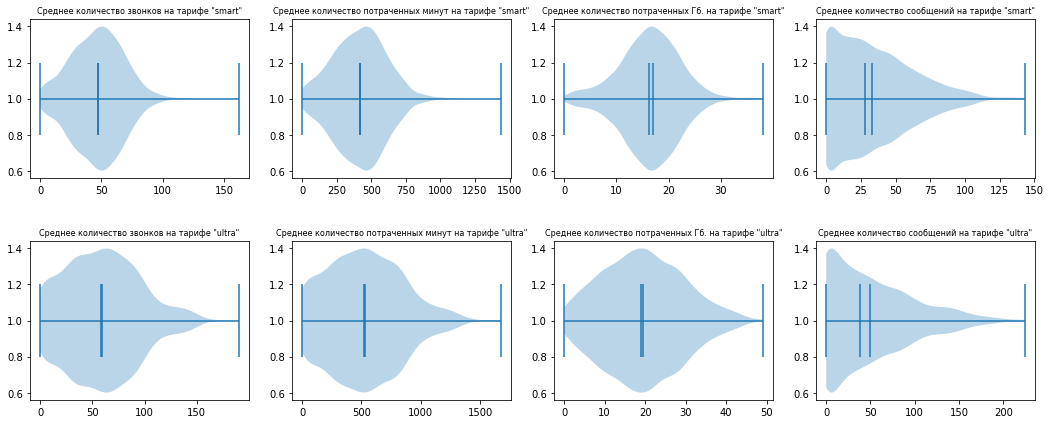

In [19]:
#Выборка пользователей по тарифу "smart"
common_data_smart_filtered = common_data[common_data['tariff'] == 'smart']

#Выборка пользователей по тарифу "ultra"
common_data_ultra_filtered = common_data[common_data['tariff'] == 'ultra']

fs=8

print ('Количество пользователей тарифа "smart":', len(common_data_smart_filtered))
print ('Количество пользователей тарифа "ultra":', len(common_data_ultra_filtered))

#Параметры поля графиков
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(18, 7))

#Размер отступа между уровнями графиков
fig.subplots_adjust(hspace=0.4)

axs[0, 0].violinplot(common_data_smart_filtered['calls_count'], points=100, widths=0.8, showmeans=True, showextrema=True, showmedians=True, vert = False)
axs[0, 0].set_title('Среднее количество звонков на тарифе "smart"', fontsize=fs)
axs[0, 1].violinplot(common_data_smart_filtered['duration_ceiled'], points=100, widths=0.8, showmeans=True, showextrema=True, showmedians=True, vert = False)
axs[0, 1].set_title('Среднее количество потраченных минут на тарифе "smart"', fontsize=fs)
axs[0, 2].violinplot(common_data_smart_filtered['gb_used'], points=100, widths=0.8, showmeans=True, showextrema=True, showmedians=True, vert = False)
axs[0, 2].set_title('Среднее количество потраченных Гб. на тарифе "smart"', fontsize=fs)
axs[0, 3].violinplot(common_data_smart_filtered['messages_count'], points=100, widths=0.8, showmeans=True, showextrema=True, showmedians=True, vert = False)
axs[0, 3].set_title('Среднее количество сообщений на тарифе "smart"', fontsize=fs)
axs[1, 0].violinplot(common_data_ultra_filtered['calls_count'], points=100, widths=0.8, showmeans=True, showextrema=True, showmedians=True, vert = False)
axs[1, 0].set_title('Среднее количество звонков на тарифе "ultra"', fontsize=fs)
axs[1, 1].violinplot(common_data_ultra_filtered['duration_ceiled'], points=100, widths=0.8, showmeans=True, showextrema=True, showmedians=True, vert = False)
axs[1, 1].set_title('Среднее количество потраченных минут на тарифе "ultra"', fontsize=fs)
axs[1, 2].violinplot(common_data_ultra_filtered['gb_used'], points=100, widths=0.8, showmeans=True, showextrema=True, showmedians=True, vert = False)
axs[1, 2].set_title('Среднее количество потраченных Гб. на тарифе "ultra"', fontsize=fs)
axs[1, 3].violinplot(common_data_ultra_filtered['messages_count'], points=100, widths=0.8, showmeans=True, showextrema=True, showmedians=True, vert = False)
axs[1, 3].set_title('Среднее количество сообщений на тарифе "ultra"', fontsize=fs)

<br>
Вычислим процент перерасхода по каждой категории для каждого тарифа.

In [20]:
smart_tariff_data = {
    'minutes': 500,
    'gigabytes':15,
    'messages':50
}

ultra_tariff_data = {
    'minutes': 3000,
    'gigabytes':30,
    'messages':1000
}

common_data_smart_filtered = common_data_smart_filtered.rename(columns={'duration_ceiled': 'minutes', 'gb_used': 'gigabytes','messages_count': 'messages' })
common_data_ultra_filtered = common_data_ultra_filtered.rename(columns={'duration_ceiled': 'minutes', 'gb_used': 'gigabytes','messages_count': 'messages' })


def overlimit(data,tariff_data):
    
    '''
    Принимает на вход таблицу с отфильтрованными по тарифам данным и таблицу со значениями лимитов минут, интернет трафика и сообщений.
    Возвращает процент случаев превышения лимита минут, интернет-трафика и сообщений сверх лимита для тарифа
    '''
    
    overlimit_percentage = []
    columns_names = []
    for i in data:                                         #Переход по колонкам в таблице    
        for j in tariff_data.keys():                       #Переход по значениям ключей таблицы описания тарифа
            if i == j:                                     #Поиск совпадений в названии столбцов и ключей таблицы описания тарифа
                overlimit_percentage.append(len(data[data[i] > tariff_data [j]][i]) / len(data[i]) * 100) #Вычисляем отношение длины списка значений, превышающих лимиты к общей длине списка отпределённого тарифа и сохраняем в отдельный Series
                columns_names.append(j)                    #Записываем в отдельный Series ключи переданного списка 'tariff_data'

    overlimit_percentage_list = pd.DataFrame([overlimit_percentage],columns = columns_names)  #Создаём DataFrame из полученных ранее значений и ключей
    return overlimit_percentage_list

smart_overlimit = overlimit(common_data_smart_filtered,smart_tariff_data)   #Применяем функцию 'overlimit' к тарифу 'smart'
ultra_overlimit = overlimit(common_data_ultra_filtered,ultra_tariff_data)   #Применяем функцию 'overlimit' к тарифу 'ultra'

overlimit_percentage_list = smart_overlimit.merge(ultra_overlimit,how = 'outer')  #Объединяем полученные ранее данные о процентах перерасхода услуг на тарифах 'smart' и 'ultra' в общую таблицу
overlimit_percentage_list ['tariff'] = ['smart', 'ultra']                          #Добавляем колонку с названиями тарифов
overlimit_percentage_list = overlimit_percentage_list.set_index('tariff', drop = True)


print (overlimit_percentage_list)

          minutes  gigabytes  messages
tariff                                
smart   33.811659  58.475336  25.29148
ultra    0.000000  13.590264   0.00000


**Вывод:** <br>
- На тарифе 'smart' свыше 58,4% пользователей тарифа перерасходуют интернет-трафик и доплачивают за него сверх абонетнтской платы. Такая же ситуация с перерасходом наблюдается для количества потраченных минут и сообщений, где перерасход случается у 33,8% и 25,3% пользователей соответственно.<br>
- В отличие от тарифа 'smart' пользователи тарифа 'ultra' лишь в 0,8% случаев от общего числа случался перерасход интернет-трафика за который они доплачивали сверх абонентской платы. По остальным услугам связи для данного тарифа перерасходов у пользователей не случалось.

<br>

Создадим сводную таблицу по тарифам для средних значений по месяцам, чтобы выяснить средние значения, дисперсию, стандартные отклонения для каждого тарифа и среднюю продолжительность звонков у пользователей каждого тарифа.

In [21]:
#Приведём тип данных 'float' к отображению не более 2-х десятичных знаков
pd.options.display.float_format = '{:.2f}'.format

#Создадим сводную таблицу для тарифов в которой рассчитаем средние значения, дисперсии и стандартные отклонения для каждого из параметров
average_profit_pivot = common_data.pivot_table (index = 'tariff', values = \
        ['calls_count','duration_ceiled','gb_used', 'messages_count','month_expenses'], aggfunc = ['mean', 'var', 'std'])

#Выясним среднюю продолжительность звонка на каждом тарифе
average_profit_pivot['average call duration'] = average_profit_pivot['mean']['duration_ceiled']/\
    average_profit_pivot['mean']['calls_count']

average_profit_pivot

mean                                                        \
       calls_count duration_ceiled gb_used messages_count month_expenses   
tariff                                                                     
smart        46.93          417.75   16.32          33.37        1289.64   
ultra        59.18          526.09   19.47          49.31        2075.70   

               var                                                        \
       calls_count duration_ceiled gb_used messages_count month_expenses   
tariff                                                                     
smart       443.44        36281.39   33.13         796.96      669730.76   
ultra      1266.98       101052.49   97.38        2285.42      142715.06   

               std                                                        \
       calls_count duration_ceiled gb_used messages_count month_expenses   
tariff                                                                     
smart        21.06          190.48    5.76          28.23         818.37   
ultra        35.59          317.89    9.87          47.81         377.78   

       average call duration  
                              
tariff                        
smart                   8.90  
ultra                   8.89

**Выводы:** <br>
<br>
- На тарифе 'smart' пользователи в среднем тратят 418 минут из доступных 500 для этого тарифа. При этом пользователи в среднем тратят на 1 GB сверх лимита и пишут в среднем 34 сообщения в месяц. Компания "Мегалайн" в среднем получает 1290 р. в месяц  дохода с каждого клиента, пользующегося тарифом 'smart' <br>
- На тарифе 'ultra' пользователи в среднем тратят 526 минут из доступных 3000 для этого тарифа. При этом пользователи в среднем тратят 19,5 GB из 30 доступных и пишут 50 сообщений в месяц. Компания "Мегалайн" в среднем получает 2076 р. в месяц дохода с каждого клиента, пользующегося тарифом 'ultra' <br>
 <br>
При сравнении указанных значений для разных тарифов можно отметить, что несмотря на существенные различия в условиях тарифов, средние значения количества минут, которые тратят пользователи ежемесячно сравнительно похожи, но стандартные отклонения при этом значительно отличаются, хотя средняя продолжительность разговоров для абонентов обоих тарифов практически совпадает. При этом стандартные отклонения для всех показателей, кроме дохода компании "Мегалайн", на тарифе 'ultra' больше, чем для тарифа 'smart', что может говорить либо о слишком малом количестве абонентов в выборке, либо о неоднородности в данной группе, например, если часть пользователей тарифа использует его в рабочих целях, что значительно выделяет их расходы среди остальных. <br>

Проанализируем доходы компании "Мегалайн" по каждому из тарифов. Для этого создадим сводную таблицу по ранее рассчитанным данным.

In [22]:
profit = common_data.pivot_table (index = 'tariff', values = ['month_expenses'], aggfunc = ['mean', 'var', 'std'])

profit

,mean,var,std
,month_expenses,month_expenses,month_expenses
tariff,,,
smart,1289.64,669730.76,818.37
ultra,2075.70,142715.06,377.78


Text(0, 0.5, 'Частота, кол-во')

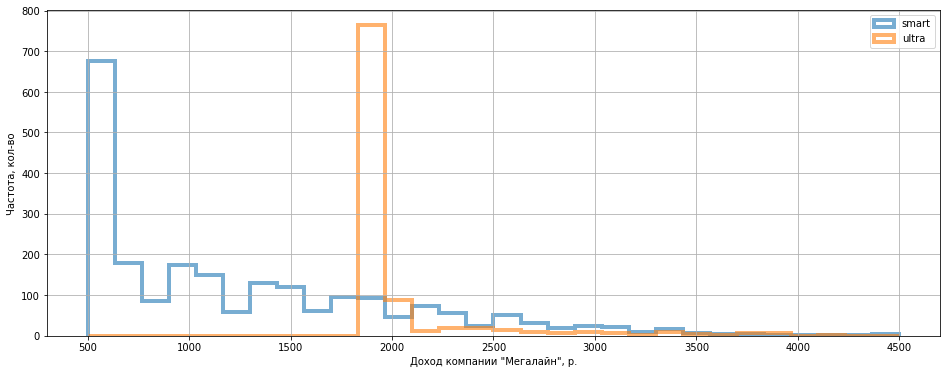

In [23]:
common_data[common_data['tariff'] == 'smart']['month_expenses'].plot(kind='hist',bins=30,histtype='step',range=(500,4500),label='smart',linewidth=4,alpha=0.6,figsize = (16,6),grid=True,legend=True)
common_data[common_data['tariff'] == 'ultra']['month_expenses'].plot(kind='hist',bins=30,histtype='step',range=(500,4500),label='ultra',linewidth=4,alpha=0.6,figsize = (16,6),grid=True,legend=True)

plt.xlabel('Доход компании "Мегалайн", р.')
plt.ylabel('Частота, кол-во')


**Вывод:**<br>
- Средний доход компании "Мегалайн" для тарифа 'smart' составляет 1290 р., а для тарифа 'ultra' - 2076 р. При этом стандартное отклонение для тарифа 'smart' составляет 818,4 р., тогда как для тарифа 'ultra' всего 377,8 р. Это может говорить о том, что на доходность сильно влияют покупаемые дополнительные пакеты услуг при перерасходе основного пакета, что подтверждается проведёнными ранее вычислениями.

# Проверка гипотез

- *Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются*

Согласно задаче следует подтвердить или опровергнуть двухсторонню гипотезу о равенстве средних значений двух выборок.<br> <br>
Для этого сформулируем Нулевую и Альтернативную гипотезы: <br>
*Нулевая гипотеза A₀* - средняя выручка пользователей тарифов «Ультра» и «Смарт» не различаются; <br>
*Альтернативная гипотеза A₁* - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются; <br>
Пороговое значение alpha зададим, как 1%.

In [24]:
#Зададим критический уровень статистической значимости (если p-value окажется меньше него - отвегнем гипотезу)
alpha = 0.01

results = st.ttest_ind(
    common_data_smart_filtered['month_expenses'], 
    common_data_ultra_filtered['month_expenses'],
    equal_var = False) #equal_var = False, т.к. размеры выборок различаются, поэтому их дисперсии так же могут быть различны

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  7.884602403811575e-253
Отвергаем нулевую гипотезу


**Вывод** <br>
- Ввиду того, что вероятность достоверности нулевой гипотезы очень мала, мы отвергаем нулевую гипотезу и принимаем альтернативную, т.е. средняя выручка для исследуемых тарифов разная.

<br>
 
- *Средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов.*

In [25]:
#Создадим выборки по Москве и регионам
moscow_profit = common_data.query('city == "Москва"')['month_expenses']
region_profit = common_data.query('city != "Москва"')['month_expenses']

Согласно задаче в этом случае, как и ранее, следует подтвердить или опровергнуть двухсторонню гипотезу о равенстве средних значений двух выборок для Москвы и всех остальных регионов.
 
Для этого сформулируем Нулевую и Альтернативную гипотезы:  
*Нулевая гипотеза H₀* - средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;  
*Альтернативная гипотеза H₁* - средняя выручка пользователи из Москвы отличается от выручки пользователей из других регионов;  
Пороговое значение alpha оставим таким же - 1%.*

In [26]:
#Зададим критический уровень статистической значимости (если p-value окажется меньше него - отвегнем гипотезу)
alpha = 0.01

results = st.ttest_ind(
    moscow_profit, 
    region_profit,
    equal_var = False) #equal_var = False, т.к. размеры выборок различаются, поэтому их дисперсии так же могут быть различны

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу") 

p-значение:  0.5130407654725258
Не получилось отвергнуть нулевую гипотезу


**Вывод:** <br>
- Вероятность подтверждения гипотезы более 51%, т.е гипотезу отвергнуть не удалось. Таким образом средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов.

# Общий вывод.

В ходе работы был проведён анализ полученных данных о пользователях двух тарифов мобильной свази компании "Мегалайн".

Условия представленных тарифов Смарт и Ультра. - В СМАРТ входит 50 сообщений, 500 минут, 15 гб, абон.плата – 550 руб. - В УЛЬТРА входит 1000 сообщений, 3000 минут, 30 ГБ, абон.плата – 1950 руб.


В ходе анализа использования представляемых услуг для каждого тарифа было установлено, что:
- На тарифе 'smart' пользователи в среднем тратят 418 минут из доступных 500 для этого тарифа. При этом пользователи в среднем тратят на 1 GB сверх лимита и пишут в среднем 34 сообщения в месяц. Компания "Мегалайн" в среднем получает 1290 р. в месяц дохода с каждого клиента, пользующегося тарифом 'smart'
- На тарифе 'ultra' пользователи в среднем тратят 526 минут из доступных 3000 для этого тарифа. При этом пользователи в среднем тратят 19,5 GB из 30 доступных и пишут 50 сообщений в месяц. Компания "Мегалайн" в среднем получает 2076 р. в месяц дохода с каждого клиента, пользующегося тарифом 'ultra' 
<br>
 
При этом:
- На тарифе 'smart' свыше 58,4% пользователей тарифа перерасходуют интернет-трафик и доплачивают за него сверх абонетнтской платы. Такая же ситуация с перерасходом наблюдается для количества потраченных минут и сообщений, где перерасход случается у 33,8% и 25,3% пользователей соответственно.
- В отличие от тарифа 'smart' пользователи тарифа 'ultra' лишь в 0,8% случаев от общего числа случался перерасход интернет-трафика за который они доплачивали сверх абонентской платы. По остальным услугам связи для данного тарифа перерасходов у пользователей не случалось.
<br>

В ходе проверки гипотез не удалось подтвердить гипотезу о том, что средняя выручка пользователей тарифов 'ultra и 'smart' не различаются, таким образом оказалось, что средние выручки для этих тарифов отличаются. При проверке второй гипотезы - наоборот, выяснилось, что средняя выручка по Москве и другим регионам практически не отличается.
<br>

В ходе исследования было установлено, что абоненты обоих тарифов тратят схожее количество минут, близки потребление трафика и количество сообщений, хотя абоненты тарифа 'ultra' тратят в среднем больше из-за более высокой арендной платы. Для компании "Мегалайн" пользователи тарифа 'ultra' приносят большую прибыль, но их общее количество меньше почти в 2 раза по сравнению с пользователями тарифа 'smart'.<br>
Несмотря на очевидную выгоду тарифа 'ultra' для компании "Мегалайн" следует отметить значительную среднюю переплату, которую несут большое количество пользователей при превышении установленных лимитов. Это обстоятельство говорит о том, что условия тарифа 'smart' не являются оптимальными для пользователей и хотя за счёт этого обстоятельства компания "Мегалайн" получает прибыль сверх расчётной, такая бизнес-модель не может считаться устойчивой, т.к. базируется на некорректном с точки зрения пользователей расчёте, когда последние в среднем несут затраты больше заявленных. Это, в свою очередь, создаёт потенциально угрожающую компании ситуацию, когда при появлении любого, чуть более выгодного для пользователей предложения, их значительное количество сможет легко отказаться от использования текущего тарифа, что в свою очередь может значительно сократить общую выручку компании.
